In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [6]:
GSD_IR = Table.read(fits.open('/Users/vestrada/Data/GOODS_IR/20150520_prior_catalogs_pgh_gs_irac_ch1.cat.fits'), format = 'fits').to_pandas()
GND_IR = Table.read(fits.open('/Users/vestrada/Data/GOODS_IR/20150520_prior_catalogs_pgh_gn_irac_ch1.cat.fits'), format = 'fits').to_pandas()

In [106]:
def Match_galaxy(gal_ra, gal_dec, gal_z500, gal_id, cat_ra, cat_dec):

    r = (1. / 60 / 60) * 0.5       

    z500= []
    ids = []

    for i in range(len(cat_ra)):
        cosr = np.sin(np.radians(cat_dec[i])) * np.sin(np.radians(gal_dec)) + np.cos(np.radians(cat_dec[i]))\
                * np.cos(np.radians(gal_dec)) * np.cos(np.radians(cat_ra[i]) - np.radians(gal_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
#         print(np.argwhere(rad == min(rad))[0])
#         print(min(rad))
        
        z500.append(gal_z500[np.argwhere(rad == min(rad))[0]][0])
        ids.append(gal_id[np.argwhere(rad == min(rad))[0]][0])    
        
    return z500, ids

In [107]:
SIR_z500, SIR_ids = Match_galaxy(v4S.ra.values, v4S.dec.values,v4S.z500.values, v4S.id.values, GSD_IR.RA, GSD_IR.DEC)
NIR_z500, NIR_ids = Match_galaxy(v4N.ra.values, v4N.dec.values,v4N.z500.values, v4N.id.values, GND_IR.RA, GND_IR.DEC)


In [147]:
# for i in range(len(GSD_IR.F24)):
#     if GSD_IR.F24[i] > 0 and SIR_ids[i] in mdb.query('field == "GSD"').id:
#         print(SIR_ids[i])
        
# for i in range(len(GND_IR.F24)):
#     if GND_IR.F24[i] > 0 and NIR_ids[i] in mdb.query('field == "GND"').id:
#         print(NIR_ids[i])

Sz = []
Sf = []
Si = []
for i in mdb.query('field == "GSD"').index:
    if mdb.id[i] in SIR_ids:
        if np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0] > 0:
            Sz.append(np.array(SIR_z500)[SIR_ids == mdb.id[i]][0])
            Sf.append(np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0])
            Si.append(mdb.id[i])
Nz = []
Nf = []
Ni = []
for i in mdb.query('field == "GND"').index:
    if mdb.id[i] in NIR_ids:
        if np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0] > 0:
            Nz.append(np.array(NIR_z500)[NIR_ids == mdb.id[i]][0])
            Nf.append(np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0])
            Ni.append(mdb.id[i])
            

In [149]:
np.array(Si)[Sf == max(Sf)]

array([44042])

(0.5, 2.5)

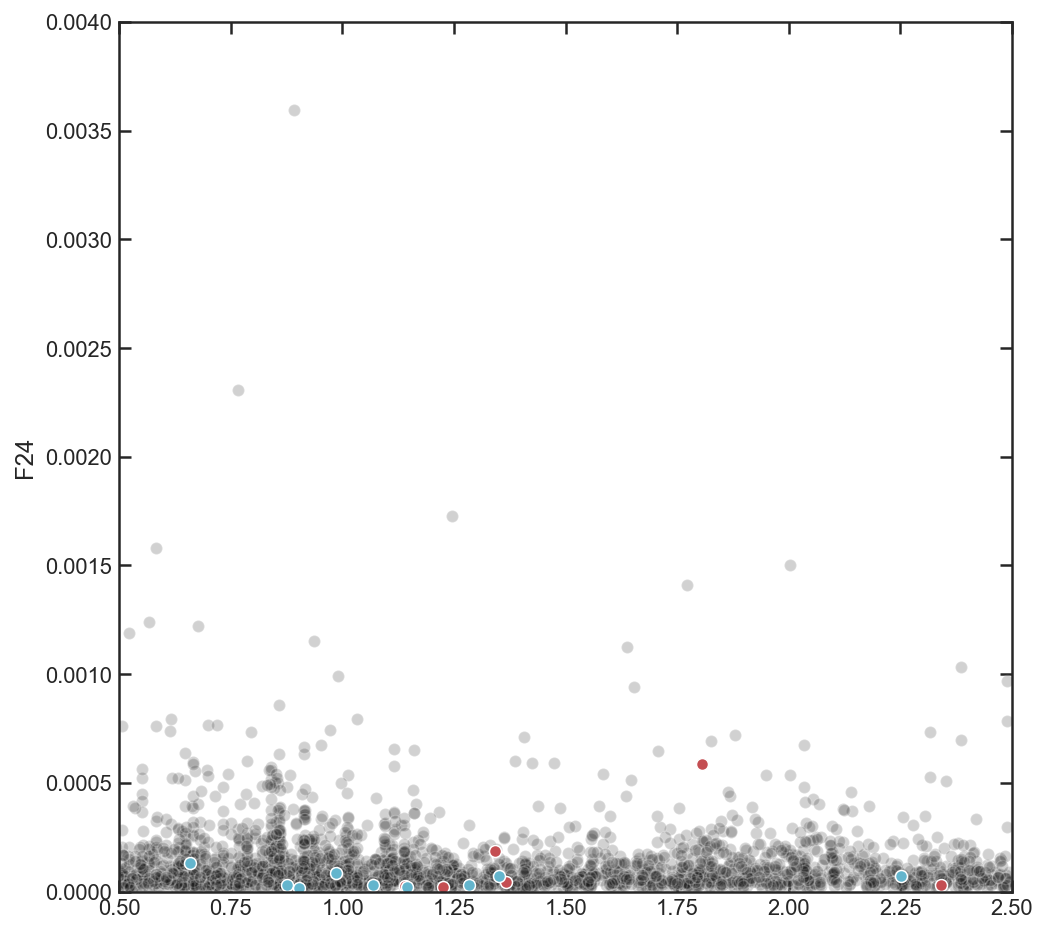

In [146]:
plt.figure(figsize=[8,8])

sea.scatterplot(SIR_z500,GSD_IR.F24, color = 'k', alpha = 0.2)
sea.scatterplot(NIR_z500,GND_IR.F24, color = 'k', alpha = 0.2)

sea.scatterplot(Sz, Sf, color = 'r')
sea.scatterplot(Nz, Nf, color = 'c')
plt.ylim(0,0.004)
plt.xlim(0.5,2.5)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


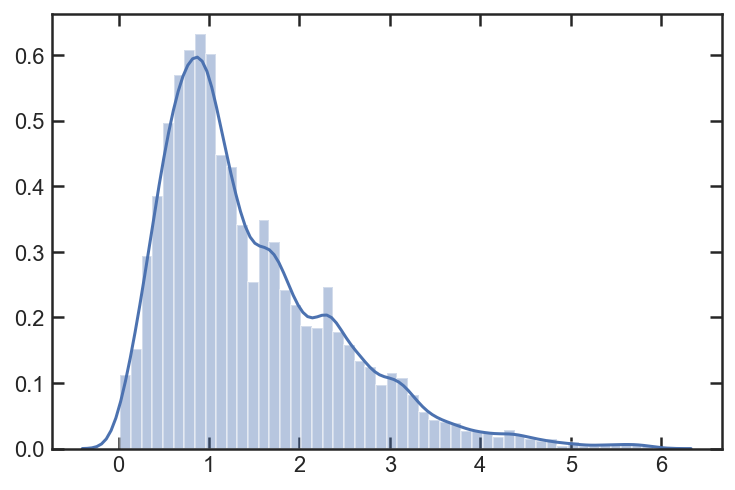

In [143]:
sea.distplot(np.append(np.array(SIR_z500)[np.array(SIR_z500) > 0],np.array(NIR_z500)[np.array(NIR_z500) > 0]))

In [142]:
np.array(SIR_z500)[np.array(SIR_z500) > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([0.53884102, 2.70767161, 0.24102386, ..., 2.33331873, 1.86450933,
       4.29841231])

# check images

In [237]:
irac1 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_SEDS1/GOODS-S_SEDS1_sci_sub.fits')
irac1_img = irac1[0].data
irac2 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_SEDS2/GOODS-S_SEDS2_sci_sub.fits')
irac2_img = irac2[0].data
irac3 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac3/GOODS-S_irac3_s2_sci.fits')
irac3_img = irac3[0].data
irac4 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac4/GOODS-S_irac4_s2_sci.fits')
irac4_img = irac4[0].data

mips = fits.open('/Volumes/Vince_CLEAR/IR_img/s_mips_1_s1_v0.30_sci.fits')
mips_img = mips[0].data

In [238]:
w1 = wcs.WCS(irac1[0].header)
w2= wcs.WCS(irac2[0].header)
w3= wcs.WCS(irac3[0].header)
w4= wcs.WCS(irac4[0].header)

wm= wcs.WCS(mips[0].header)

In [239]:
[pos1]=w1.wcs_world2pix([[v4S.query('id == 44042').ra.values[0] ,v4S.query('id == 44042').dec.values[0]]],1)
[pos2]=w2.wcs_world2pix([[v4S.query('id == 44042').ra.values[0] ,v4S.query('id == 44042').dec.values[0]]],1)
[pos3]=w3.wcs_world2pix([[v4S.query('id == 44042').ra.values[0] ,v4S.query('id == 44042').dec.values[0]]],1)
[pos4]=w4.wcs_world2pix([[v4S.query('id == 44042').ra.values[0] ,v4S.query('id == 44042').dec.values[0]]],1)

[posm]=wm.wcs_world2pix([[v4S.query('id == 44042').ra.values[0] ,v4S.query('id == 44042').dec.values[0]]],1)

In [243]:
gal_img1 = irac1_img[int(pos1[0])-100: int(pos1[0])+100 , int(pos1[1])-100:int(pos1[1])+100]
gal_img2 = irac2_img[int(pos2[0])-100: int(pos2[0])+100 , int(pos2[1])-100:int(pos2[1])+100]
gal_img3 = irac3_img[int(pos3[0])-100: int(pos3[0])+100 , int(pos3[1])-100:int(pos3[1])+100]
gal_img4 = irac4_img[int(pos4[0])-100: int(pos4[0])+100 , int(pos4[1])-100:int(pos4[1])+100]

gal_imgm = mips_img[int(posm[0])-100: int(posm[0])+100 , int(posm[1])-100:int(posm[1])+100]

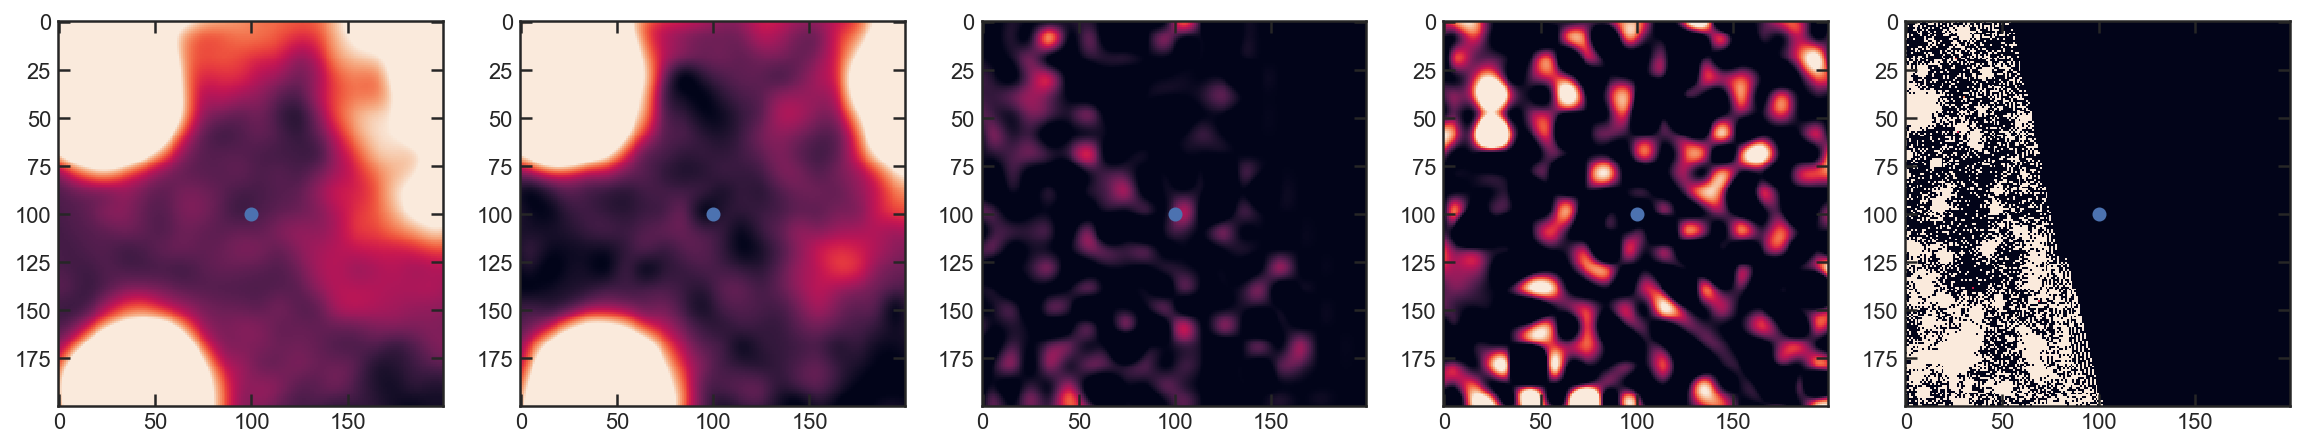

In [246]:
gs = gridspec.GridSpec(1,5)

plt.figure(figsize=[20,8])

plt.subplot(gs[0])
plt.imshow(gal_img1, vmin = 0, vmax = 0.0001)
plt.scatter([100],[100])

plt.subplot(gs[1])
plt.imshow(gal_img2, vmin = 0, vmax = 0.0001) 
plt.scatter([100],[100])

plt.subplot(gs[2])
plt.imshow(gal_img3, vmin = 0, vmax = 0.001) 
plt.scatter([100],[100])

plt.subplot(gs[3])
plt.imshow(gal_img4, vmin = 0, vmax = 0.001) 
plt.scatter([100],[100])

plt.subplot(gs[4])
plt.imshow(gal_imgm, vmin = 0, vmax = 0.0001) 
plt.scatter([100],[100])


In [190]:
irac1_img.shape, pos

((2400, 2220), array([1207.07939926, 1798.50147902]))

In [193]:
irac1[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2220 / Axis length                                    
NAXIS2  =                 2400 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '18:33:41 (09/05/2005)' / Time of last modification                   
OBJECT  = 'GOODS-S superdeep epoch 1 IRAC channel 1' / Name of the object observ
                                                                                
TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        
INSTRUME= 'IRAC    '           / SPITZER Space Telescope instrument ID          
CHNLNUM =                   